# Spark RDD

* Last updated 20170515 20170221 20161125

## S.1 학습내용

### S.1.1 목표

* 파일, JSON 등에서 RDD를 생성할 수 있다.
* RDD API를 사용할 수 있다.

### S.1.2 목차

* S.2 Data를 사용하는 API 
* S.3 SparkSession
* S.3.1 Spark 2.0 vs 1.6 
* S.3.2 SparkContext
* S.3.3 IPython Notebook에서 SparkSession 생성하기
* S.4 RDD 소개
* S.5 RDD 생성
* S.6 RDD API 
* S.6.1 비슷한 Python 함수
* S.6.2 RDD 사용하기
* S.7 spark-submit

### S.1.3 문제

* 문제 S-1: Hello Spark - 환경설정을 읽어 클라이언트를 생성하기.
* 문제 S-2: RDD를 사용하여 word count를 계산하고 그래프 그리기.
* 문제 S-3: RDD를 사용하여 word vector를 생성하기.

## S.2 데이터를 사용하는 API

* Spark는 RDD, Dataframe, DataSet으로 구분하여, 데이터구조를 사용한다.
* 이 중 RDD는 버전 1.0부터 사용되었고, 다른 데이터구조는 RDD를 기반으로 만들어졌다.
* 현재 RDD API에 대한 지원은 축소되고 있다.

데이터구조 | 도입된 spark version | 설명
---------|---------|---------
RDD | Spark 1.0 | unstructured, schema free, low-level
Dataframe | 1.3 | semi 또는 structured, schema를 가진다. Dataset[Row]와 같은 의미로, 타잎을 강제하지 않는다.
Dataset | 1.6 | 자바의 Generic과 같이 Dataset[T]으로 '타잎'을 강제하는 형식이다. Scala and Java에서 사용한다. Python loosely-typed이므로 사용하지 않는다.


* RDD는 데이터가 비구조적인 경우 사용하기 적합하다. 모델schema를 정하지 않고 사용할 수 있다.
* RDD는 하위수준의 API를 제공하고, 다른 데이터구조는 schema 및 데이터타잎을 지원하게 된다.
* DataFrame과 DataSet은 데이터가 구조적인 경우 사용한다.
* Spark의 RDD, DataFrame 모두 immutable
* Spark의 데이터는 모두 lazy (실제 transformation을 action까지 연기)
* Spark에서 모든 transformations이 연기된다는 lazy의 의미는:
    * 변환을 하여 메모리에 가지고 있는 비효율성
    * 실제 action이 실행되는 경우, 계산이 이루어지고, 실제 메모리를 사용한다.
    * RDD의 경우, action이 실행될 때마다 재계산이 이루어지는 것을 막기 위해 persist (or cache)함수를 사용할 수 있다.


## S.3 SparkSession

### S.3.1 Spark 2.0 vs 1.6

* Spark 2.0부터는 SparkSession으로 시작점을 통합해서, 개별적인 Context를 모두 통합해서 'pyspark.sql.SparkSession'를 사용한다.

```
spark = SparkSession.builder.getOrCreate()
```

Context 구분 | 설명 | 2.0의 사용 예 | 1.x의 사용 예
----------|----------|----------|----------
SparkContext | RDD를 사용하는 Context | spark.SparkContext | SparkContext()
StreamingContext | 향후 제공 | |
SQLContext | Spark SQL, DataFrame | spark.sql | SQLContext(SparkContext)
HiveContext | HiveQL, DataFrame | spark.sql | HiveContext(SparkContext)


* 이전 1.x 버전에서는 SparkContext를 통해 다른 Context를 사용했고, 호환성을 제공하므로 그대로 사용할 수도 있다.
* Spark 1.6에서는 다음과 같이 사용한다.

```
import pyspark
conf=pyspark.SparkConf()
conf = pyspark.SparkConf().setAppName("myAppName")
sc = pyspark.SparkContext(conf=conf) #SparkContext를 직접 생성한다.
sqlContext = SQLContext(sc)   #SparkContext를 넣어서 SQLContext를 생성
```

### S.3.2 SparkContext

* Spark 서버(클러스터)에 대한 클라이언트와 같은 역할을 한다.
* 클러스터를 어떻게 사용할 것인지 정한다. cluster manager에서 system resource를 할당받는다 (cpu, memory, machine)
* Python의 SparkContext는 jar를 분산환경에서 사용하게 되므로 주의 (Scala, Java와 다름)
    * pyFiles에 사용할 (의존적인) 라이브러리를 넣는다 (또는 사용할 라이브러리가 없으면 빈 파일로 둔다).

* Cannot run multiple SparkContexts at once;
    * sc가 이미 있는 경우 sc.stop()

```
from pyspark import SparkContext
sc = SparkContext("master","my python app", sparkHome="sparkhome",pyFiles="placeholderdeps.zip")
```


### S.3.3 IPython Notebook에서 SparkSession 생성하기

* Spark에서 pyspark shell을 제공하고 있다.
* 이 강의에서는 ipython notebook에서 pyspark를 사용하기로 한다.


## 문제 S-1: Hello Spark, 환경설정을 읽어 클라이언트 생성하기.

* 설정을 변경한다.

설정 항목 | 설명
----------|----------
SPARK_HOME | Spark가 설치된 경로로 수정한다.
PYTHONPATH | sys.path.insert()를 사용하여 'PYTHONPATH'를 수정한다. pyspark.zip, py4j-0.10.1-src.zip를 추가


* 윈도우
    * 'HOME'이 설정되어 있지 않으므로, expanduser('~')를 사용한다.
```
os.path.expanduser("~")
```

    * Backslash Continuation은 사용하지 않는다.

In [1]:
import os
import sys 
os.environ["SPARK_HOME"]=os.path.join(os.environ['HOME'],'Downloads','spark-2.0.0-bin-hadoop2.7')
os.environ["PYLIB"]=os.path.join(os.environ["SPARK_HOME"],'python','lib')
sys.path.insert(0,os.path.join(os.environ["PYLIB"],'py4j-0.10.1-src.zip'))
sys.path.insert(0,os.path.join(os.environ["PYLIB"],'pyspark.zip'))

In [2]:
for i in sys.path:
    print i

/home/jsl/Downloads/spark-2.0.0-bin-hadoop2.7/python/lib/pyspark.zip
/home/jsl/Downloads/spark-2.0.0-bin-hadoop2.7/python/lib/py4j-0.10.1-src.zip

/usr/lib/python2.7
/usr/lib/python2.7/plat-x86_64-linux-gnu
/usr/lib/python2.7/lib-tk
/usr/lib/python2.7/lib-old
/usr/lib/python2.7/lib-dynload
/home/jsl/.local/lib/python2.7/site-packages
/usr/local/lib/python2.7/dist-packages
/usr/lib/python2.7/dist-packages
/usr/lib/python2.7/dist-packages/PILcompat
/usr/lib/python2.7/dist-packages/gtk-2.0
/usr/lib/python2.7/dist-packages/ubuntu-sso-client
/usr/local/lib/python2.7/dist-packages/IPython/extensions
/home/jsl/.ipython


* spark warehouse dir
```
.config('spark.sql.warehouse.dir', 'file:////home/jsl/Code/git/bb/jsl/pyds/data/')
```

In [3]:
import pyspark
myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession.builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

* 설정을 읽어 온다.
    * spark-defaults.conf와 같은 파일의 값을 읽어서 설정

In [10]:
print spark.version
print spark.conf.get('spark.app.name')
print spark.conf.get('spark.master')
print spark.conf.get('spark.driver.host')

2.0.0
pyspark-shell
local[*]
117.16.44.45


In [7]:
print spark.conf.get('spark.jars.packages')

graphframes:graphframes:0.4.0-spark2.0-s_2.11,org.mongodb.spark:mongo-spark-connector_2.10:2.0.0,com.databricks:spark-csv_2.11:1.5.0


## S.4 RDD 소개

* RDD (Resilient Distributed Dataset)는 레코드records의 집합으로, 여러 컴퓨터에 분산해서 사용할 수 있는 데이터 형식이다.
    * Resilient - fault tolerent (어느 한 노드에서 작업이 실패하면 다른 노드에서 실행된다.)
    * Distributed - multiple nodes in a clusters
    * Dataset - 데이터타잎으로 구성된다.
* RDD는 내, 외부 자료에서 생성하며, 생성된 자료는 read-only이다.
    * HDFS 파일을 처리할 수 있다.

## S.5 RDD 생성

* 외부 파일 또는 배열과 같은 자료구조에서 읽어서 생성하고, 생성된 RDD는 분산하여 처리할 수 있게 된다.

생성 방법 | 설명 | 함수
----------|----------|----------
외부에서 읽기 | 파일, HDFS, HBase 등 | textFile("mydir/")<br>textFile("mydir/*.txt")<br>textFile("mydir/*.gz")<br>Hadoop InputFormat
내부에서 읽기 | Pytho list에서 생성 | parallelize()


* Python list에서 RDD 생성하기
* SparkSession을 통하거나 또는 직접 SparkContext를 사용할 수 있다.

In [5]:
myList=[1,2,3,4,5,6,7]
myRdd1 = spark.sparkContext.parallelize(myList)
myRdd1.take(3)

[1, 2, 3]

* 파일에서 RDD 생성하기
    * Apache spark wiki에서 첫 문단을 복사해 왔다.
    * 3째줄은 한글, 4째 줄은 같은 단어를 반복해 추가했다.

In [6]:
%%writefile data/ds_spark_wiki.txt
Wikipedia
Apache Spark is an open source cluster computing framework.
아파치 스파크는 오픈 소스 클러스터 컴퓨팅 프레임워크이다.
Apache Spark Apache Spark Apache Spark Apache Spark
아파치 스파크 아파치 스파크 아파치 스파크 아파치 스파크
Originally developed at the University of California, Berkeley's AMPLab,
the Spark codebase was later donated to the Apache Software Foundation,
which has maintained it since.
Spark provides an interface for programming entire clusters with
implicit data parallelism and fault-tolerance.

Overwriting data/ds_spark_wiki.txt


* 비교

구분 | 설명
-----|-----
SparkSession.sparkContext.textFile() | 'SparkContext'를 사용하므로 RDD를 생성한다.
SparkSession.read.text() | DataFrame을 생성한다.

In [9]:
import os
myDf=spark.read.text(os.path.join("data", "ds_spark_wiki.txt"))
print myDf.take(1)

<class 'pyspark.sql.dataframe.DataFrame'>
[Row(value=u'Wikipedia')]


In [4]:
myRdd2=spark.sparkContext\
    .textFile(os.path.join("data","ds_spark_wiki.txt"))
print myRdd2.first()

Wikipedia


* csv에서 RDD 생성하기

In [ ]:
%%writefile ./data/ds_spark_2cols.csv
35, 2
40, 27
12, 38
15, 31
21, 1
14, 19
46, 1
10, 34
28, 3
48, 1
16, 2
30, 3
32, 2
48, 1
31, 2
22, 1
12, 3
39, 29
19, 37
25, 2

* RDD를 파일에서 읽어 생성하면, 전체가 하나의 record가 된다.
* map()함수를 사용하면, 여러 record로 분리 된다.

In [11]:
myRdd3 = spark.sparkContext\
    .textFile(os.path.join("data","ds_spark_2cols.csv"))
myRdd3.take(5)

[u'35, 2', u'40, 27', u'12, 38', u'15, 31', u'21, 1']

In [12]:
myRdd4 = myRdd3.map(lambda line: line.split(','))
myRdd4.take(5)

[[u'35', u' 2'],
 [u'40', u' 27'],
 [u'12', u' 38'],
 [u'15', u' 31'],
 [u'21', u' 1']]

## S.6 RDD API

* Transformations, Actions로 구분할 수 있다. Dataframe의 Transformer, Estimator와 비교할 수 있다.
* 변환 transformations
    * lazy연산을 한다. 즉, 실제 변환은 action이 수행되는 시점에 이루어진다.
    * 결과는 RDD 또는 seq(RDD)

함수 | 설명 | 예제
-------|-------|-------
map(fn) | 요소별로 fn을 적용해서 결과 RDD 돌려줌 | .map(lambda x: x.split(' ')
filter(fn) | 요소별로 선별하여 fn을 적용해서 결과 RDD 돌려줌 | .filter(lambda x: "Spark" in x)
flatMap(fn) | 요소별로 fn을 적용하고, flat해서 결과 RDD 돌려줌 | .flatMap(lambda x: x.split(' '))
groupByKey() | key를 그룹해서 iterator를 돌려줌. |

* actions
    * RDD를 값으로 변환한다. 예, Python list

함수 | 설명 | 예제
-------|-------|-------
reduce(fn) | 요소별로 fn을 사용해서 줄여서 결과 list를 돌려줌 |
collect() | 모든 요소를 결과 list로 돌려줌 |
count() | 요소의 갯수를 결과 list로 돌려줌 |
countByKey() | key별 함수 |
foreach(fn) | 각 데이터 항목에 함수fn을 적용 |

###  S.6.1 비슷한 Python 함수

* map, reduce, filter
    * 함수의 인자는 2개가 필요하다 (함수, 데이터).

함수 | 설명 | 예
-------|-------|-------
map() | 각 데이터 요소에 함수를 적용해서 list를 반환 | map(fn,data)
filter() | 각 데이터 요소에 함수의 결과 True를 선택해서 반환 | filter(fn, data)
reduce() | 각 데이터 요소에 함수를 적용해서 list를 반환 | reduce(fn, data)

* Python 함수로 처리한다.
    * 입출력은 데이터 하나씩이 아니라, list로 한다.

In [17]:
celsius = [39.2, 36.5, 37.3, 37.8]
def c2f(c):
    f=list()
    for i in c:
        _f=(float(9)/5)*i + 32
        f.append(_f)
    return f

print c2f(celsius)

[102.56, 97.7, 99.14, 100.03999999999999]


* Python에서 제공하는 map() 함수를 사용한다. map() 함수의 인자:
    * (1) 함수명 (함수의 return은 반드시 있어야 한다.)
    * (2) 입력인자

In [18]:
celsius = [39.2, 36.5, 37.3, 37.8]
def c2f(c):
    return (float(9)/5)*c + 32

f=map(c2f, celsius)
print f

[102.56, 97.7, 99.14, 100.03999999999999]


* lambda함수를 사용한다.
    * lambda는 무명 함수이다.
    * 처리 결과는 'return'을 사용하지 않아도 반환된다.

In [19]:
map(lambda c:(float(9)/5)*c + 32, celsius)

[102.56, 97.7, 99.14, 100.03999999999999]

* 문자열에 map()을 사용한다.

In [20]:
sentence = 'Hello World'
words = sentence.split()
print words

['Hello', 'World']


* 문자열을 사용하면, 각 단어를 split()한다.
* list를 사용하면, 각 요소를 split()한다.

In [21]:
sentence = "Hello World"
map(lambda x:x.split(),sentence)

[['H'], ['e'], ['l'], ['l'], ['o'], [], ['W'], ['o'], ['r'], ['l'], ['d']]

In [22]:
sentence = ["Hello World"]
map(lambda x:x.split(),sentence)

[['Hello', 'World']]

* filter()는 데이터를 선별한다.

In [37]:
fib = [0,1,1,2,3,5,8,13,21,34,55]
result = filter(lambda x: x % 2, fib)
print result

[1, 1, 3, 5, 13, 21, 55]


* reduce()는 2개의 인자를 받는다.
* [ func(func(s1, s2),s3), ... , sn ]와 같이 수행한다.
* x,y 인자는 두 수를 반복해서 더한다는 의미로 사용한다.

In [36]:
reduce(lambda x, y: x+y, range(1,101))

5050

## S.6.2 RDD 사용하기

* transformation, action을 사용한다.
* lambda함수를 또는 사용자함수를 사용한다.

* map(), collect() 사용해서 square

In [4]:
nRdd = spark.sparkContext.parallelize([1, 2, 3, 4])
squared = nRdd.map(lambda x: x * x).collect()
print squared

[1, 4, 9, 16]


* reduce()를 사용해서 합계

In [7]:
myRdd100 = spark.sparkContext.parallelize(range(1,101))
myRdd100.reduce(lambda x,y: x+y)

5050

* 단순 통계 기능

In [10]:
print nRdd.sum(), nRdd.min(), nRdd.max(), nRdd.stdev(), nRdd.variance()

10 1 4 1.11803398875 1.25


* map()함수로 단어 분리하기

In [29]:
words=myRdd2.map(lambda x:x.split(' '))

In [30]:
words.count()

9

* lambda아닌 사용자함수로 map()

In [13]:
def mySplit(x):
    return x.split(" ")

words=myRdd2.map(mySplit)

In [14]:
words.count()

10

In [17]:
words.take(3)

[[u'Wikipedia'],
 [u'Apache',
  u'Spark',
  u'is',
  u'an',
  u'open',
  u'source',
  u'cluster',
  u'computing',
  u'framework.'],
 [u'\uc544\ud30c\uce58',
  u'\uc2a4\ud30c\ud06c\ub294',
  u'\uc624\ud508',
  u'\uc18c\uc2a4',
  u'\ud074\ub7ec\uc2a4\ud130',
  u'\ucef4\ud4e8\ud305',
  u'\ud504\ub808\uc784\uc6cc\ud06c\uc774\ub2e4.']]

In [21]:
for line in words.collect():
    for word in line:
        print word,
    print "\n-----"

Wikipedia 
-----
Apache Spark is an open source cluster computing framework. 
-----
아파치 스파크는 오픈 소스 클러스터 컴퓨팅 프레임워크이다. 
-----
Apache Spark Apache Spark Apache Spark Apache Spark 
-----
아파치 스파크 아파치 스파크 아파치 스파크 아파치 스파크 
-----
Originally developed at the University of California, Berkeley's AMPLab, 
-----
the Spark codebase was later donated to the Apache Software Foundation, 
-----
which has maintained it since. 
-----
Spark provides an interface for programming entire clusters with 
-----
implicit data parallelism and fault-tolerance. 
-----


* 각 문장의 철자 갯수를 센다.
    * 첫 문장 'Wiskipedia'는 9

In [35]:
myRdd2.map(lambda s:len(s)).collect()

[9, 59, 32, 51, 72, 71, 30, 64, 46]

* filter()

In [38]:
myRdd_spark=myRdd2.filter(lambda line: "Spark" in line)

In [39]:
print myRdd_spark.count()

4


* 한글은 앞에 u를 붙여준다.

In [40]:
myRdd_unicode = myRdd2.filter(lambda line: u"스파크" in line)

In [41]:
print myRdd_unicode.first()

아파치 스파크는 오픈 소스 클러스터 컴퓨팅 프레임워크이다.


* filter()를 사용해서 stopwords 제거하기
    * 문장 안에 stopwords를 포함한 경우는 제거되지 않는다.

In [42]:
stopwords = ['is','am','are','the','for','a']
myRdd_stop = myRdd2.filter(lambda x: x not in stopwords)
myRdd_stop.take(5)

[u'Wikipedia',
 u'Apache Spark is an open source cluster computing framework.',
 u'\uc544\ud30c\uce58 \uc2a4\ud30c\ud06c\ub294 \uc624\ud508 \uc18c\uc2a4 \ud074\ub7ec\uc2a4\ud130 \ucef4\ud4e8\ud305 \ud504\ub808\uc784\uc6cc\ud06c\uc774\ub2e4.',
 u'Apache Spark Apache Spark Apache Spark Apache Spark',
 u"Originally developed at the University of California, Berkeley's AMPLab,"]

* 문장 처리하기
* 단어를 교체하기

In [45]:
a=["this is","a line"]
_rdd=spark.sparkContext.parallelize(a)

words=_rdd.map(lambda x:x.split())
print words.collect()

[['this', 'is'], ['a', 'line']]


In [46]:
_upper=_rdd.map(lambda x:x.replace("a","AA"))
_upper.take(10)

['this is', 'AA line']

* 첫 글자를 대문자로 만들어서 출력해 보기

In [47]:
's'.upper()

'S'

In [48]:
pluralRDD =words.map(lambda x: x[0].upper())
print pluralRDD.collect()

['THIS', 'A']


In [49]:
pluralRDD =words.map(lambda x: [i.upper() for i in x])
print pluralRDD.collect()

[['THIS', 'IS'], ['A', 'LINE']]


* transformation(map()), action(collect()) 함수를 한꺼번에

In [40]:
pluralRDD=words.map(lambda x: [i.upper() for i in x]).collect()
print pluralRDD

[['THIS', 'IS'], ['A', 'LINE']]


In [41]:
wordsLength = words\
    .map(len)\
    .collect()
print wordsLength

[2, 2]


* 파일에 쓰기

In [6]:
pluralRDD.saveAsTextFile("data/ds_spark_wiki1.txt")

In [ ]:
spark.conf.set()

* groupBy
    * 앞 2글자를 key로 사용해서, groupBy()
    * 결과는 key-value, value는 iterator

In [6]:
myRdd2=spark.sparkContext\
    .textFile(os.path.join("data","ds_spark_wiki.txt"))

In [5]:
myRdd2.take(10)

[u'Wikipedia',
 u'Apache Spark is an open source cluster computing framework.',
 u'\uc544\ud30c\uce58 \uc2a4\ud30c\ud06c\ub294 \uc624\ud508 \uc18c\uc2a4 \ud074\ub7ec\uc2a4\ud130 \ucef4\ud4e8\ud305 \ud504\ub808\uc784\uc6cc\ud06c\uc774\ub2e4.',
 u'Apache Spark Apache Spark Apache Spark Apache Spark',
 u'\uc544\ud30c\uce58 \uc2a4\ud30c\ud06c \uc544\ud30c\uce58 \uc2a4\ud30c\ud06c \uc544\ud30c\uce58 \uc2a4\ud30c\ud06c \uc544\ud30c\uce58 \uc2a4\ud30c\ud06c',
 u"Originally developed at the University of California, Berkeley's AMPLab,",
 u'the Spark codebase was later donated to the Apache Software Foundation,',
 u'which has maintained it since.',
 u'Spark provides an interface for programming entire clusters with',
 u'implicit data parallelism and fault-tolerance.']

* 앞 2글자로 grouping

In [8]:
#myRdd_group=myRdd2.flatMap(lambda x:x.split()).groupBy(lambda x:w[0:2])
myRdd_group=myRdd2.groupBy(lambda x:x[0:2])

for (k,v) in myRdd_group.collect():
    for eachValue in v:
        print k, eachValue
    print "-----"

아파 아파치 스파크는 오픈 소스 클러스터 컴퓨팅 프레임워크이다.
아파 아파치 스파크 아파치 스파크 아파치 스파크 아파치 스파크
-----
im implicit data parallelism and fault-tolerance.
-----
th the Spark codebase was later donated to the Apache Software Foundation,
-----
Wi Wikipedia
-----
Ap Apache Spark is an open source cluster computing framework.
Ap Apache Spark Apache Spark Apache Spark Apache Spark
-----
Sp Spark provides an interface for programming entire clusters with
-----
Or Originally developed at the University of California, Berkeley's AMPLab,
-----
wh which has maintained it since.
-----


* pair RDD

구분 | 설명
-----|-----
byKey | 동일한 키에 대해 연산<br>- 단계 1: key-value를 계산한다. 각 key의 빈도를 계산  '(key,1)'<br>- 단계 2: byKey를 적용한다. 동일한 key의 value를 더해준다.
byValue | 예, mapValues



구분 | 설명
-----|-----
groupByKey | 같은 key를 grouping, 부분partition에서 먼저 reduce하지 않고, 전체로 계산한다.
reduceByKey | 같은 key를 reduce, 부분partition에서 먼저 reduce하고, 전체로 계산한다. grouping + aggregation. 즉 reduceByKey = groupByKey().reduce()
aggregateByKey() | reduceByKey()와 유사하지만 결과를 다른 형식으로 반환. For example (1,2),(1,4) as input and (1,"six") as output
mapValues | value에 적용

* reduceByKey - key별로 value를 합쳐서 결과 -> 아래는 a,3 b,2
```
("a", 1)
("b", 1)
("a", 1)
("a", 1)
("b", 1)
```

* 데이터 예

P1 | P2 | P3
-----|-----|-----
(key1,1)<br> | (key1,1)<br> | (key1,1)<br>
(key1,1)<br> | (key2,1)<br> | (key1,1)<br>
(key1,1)<br> |              | (key2,1)<br>
(key2,1)<br> |              | (key2,1)<br>
(key2,1)<br> |              |

* reduceByKey: (key1,6) (key2,5)

P1 | P2 | P3
-----|-----|-----
(key1,3)<br>(key2,2) | (key1,1)<br>(key2,1) | (key1,2)<br>(key2,2)

* groupByKey: (key1,6) (key2,5)

key1 | key2
-----|-----
(key1,1)<br>(key1,1)<br>(key1,1)<br>(key1,1)<br>(key1,1)<br>(key1,1) | (key2,1)<br>(key2,1)<br>(key2,1)<br>(key2,1)<br>(key2,1)

* flatMap()은 결과를 flatten해서, 단어의 갯수를 셀 수 있게 한다. 반면 map()은 그렇지 못하다.
* groupByKey()는 key를 묶어준다.
* 따라서 iterator를 반환한다.

In [8]:
myRdd2\
    .flatMap(lambda x:x.split())\
    .map(lambda x:(x,1))\
    .groupByKey()\
    .take(3)

[(u'and', <pyspark.resultiterable.ResultIterable at 0x7fc74f5bd390>),
 (u'\uc18c\uc2a4', <pyspark.resultiterable.ResultIterable at 0x7fc74f5bd090>),
 (u'is', <pyspark.resultiterable.ResultIterable at 0x7fc74f5bd190>)]

* groupBy()를 한 후 mapValues(sum)을 하면 key별 합계를 구할 수 있다.
* mapValues()는 기능을 value에 적용하는 함수
    * 내장함수 sum()은 value의 합계를 내는 sum(value)을 의미
    * 사용자 함수를 정의해서 사용할 수 있다.

In [10]:
myRdd2\
    .flatMap(lambda x:x.split())\
    .map(lambda x:(x,1))\
    .groupByKey()\
    .mapValues(sum)\
    .take(10)

[(u'and', 1),
 (u'\uc18c\uc2a4', 1),
 (u'is', 1),
 (u'Wikipedia', 1),
 (u'AMPLab,', 1),
 (u'maintained', 1),
 (u'donated', 1),
 (u'\ucef4\ud4e8\ud305', 1),
 (u'open', 1),
 (u'since.', 1)]

In [12]:
def f(x): return len(x)
myRdd2\
    .flatMap(lambda x:x.split())\
    .map(lambda x:(x,1))\
    .groupByKey()\
    .mapValues(f)\
    .sortByKey(True)\
    .take(10)

[(u'AMPLab,', 1),
 (u'Apache', 6),
 (u"Berkeley's", 1),
 (u'California,', 1),
 (u'Foundation,', 1),
 (u'Originally', 1),
 (u'Software', 1),
 (u'Spark', 7),
 (u'University', 1),
 (u'Wikipedia', 1)]

* for문을 사용해서 출력을 할 수 있다.

In [10]:
wc=myRdd2\
    .flatMap(lambda x:x.split())\
    .map(lambda x:(x,1))\
    .groupByKey()\
    .mapValues(sum)\
    .sortByKey(True)\
    .take(10)

In [11]:
for e in wc:
    print e

(u'AMPLab,', 1)
(u'Apache', 6)
(u"Berkeley's", 1)
(u'California,', 1)
(u'Foundation,', 1)
(u'Originally', 1)
(u'Software', 1)
(u'Spark', 7)
(u'University', 1)
(u'Wikipedia', 1)


## 문제 S-2: RDD를 사용하여 word count를 계산하고 그래프 그리기.

* reduceByKey
    * 같은 key에 대해 그 value를 reduce

In [24]:
wc2=myRdd2\
    .flatMap(lambda x:x.split())\
    .map(lambda x:(x,1))\
    .reduceByKey(lambda x,y:x+y)\
    .map(lambda x:(x[1],x[0]))\
    .sortByKey(False)\
    .take(10)

In [25]:
print type(wc2)
for i in wc2:
    print i

<type 'list'>
(7, u'Spark')
(6, u'Apache')
(5, u'\uc544\ud30c\uce58')
(4, u'\uc2a4\ud30c\ud06c')
(3, u'the')
(2, u'an')
(1, u'and')
(1, u'\uc18c\uc2a4')
(1, u'is')
(1, u'Wikipedia')


* barh() horizontal bar chart

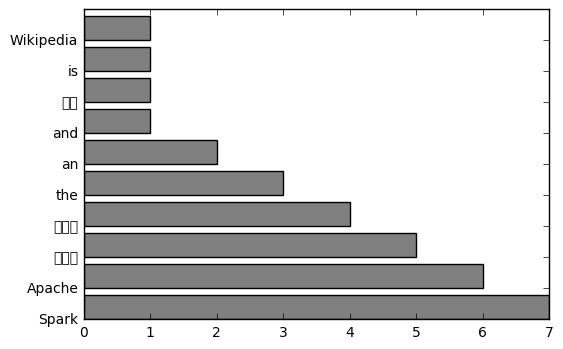

In [27]:
% matplotlib inline
import matplotlib.pyplot as plt

count = map(lambda x: x[0], wc2)
word = map(lambda x: x[1], wc2)
plt.barh(range(len(count)), count, color = 'grey')
plt.yticks(range(len(count)), word)
plt.show()

* combineByKey(x, y, z)

구분 | 함수명 | 설명
-----|-----|-----
x | Combiner 함수 | 값을 combine (V) -> C 예: (value,1)
y | Merge value 함수 | 값을 merge (C, V) -> C 예: (sum,count)
z | Merge combiners 함수 | combiner를 merge (C, C) -> C) 예: (K, C)

데이터 | 적용 함수 | 결과
-----|-----|-----
('kim',86) | combiner | kim, (86,1)
('lim',87) | combiner | lim, (87,1)
('kim',75) | merge value | (86,1)+(75,1) = (161,2)
('kim',91) | merge value | (161,2)+(91,1) = (252,3)
('lim',78) | merge value | (87,1)+(78,1) = (165,2)
('lim',92) | merge value | (165,2)+(92,1) = (257,3)
('lim',79) | merge value | (257,3)+(79,1) = (336,4)
('lee',99) | combiner | (99,1)

In [18]:
marks = spark.sparkContext.parallelize([('kim',86),('lim',87),('kim',75),
                                      ('kim',91),('lim',78),('lim',92),
                                      ('lim',79),('lee',99)])
marksByKey = marks.combineByKey(lambda value: (value,1),
                             lambda x,value: (x[0]+value, x[1]+1),
                             lambda x,y: (x[0]+y[0], x[1]+y[1]))
marksByKey.collect()

[('lim', (336, 4)), ('lee', (99, 1)), ('kim', (252, 3))]

In [21]:
heights = spark.sparkContext.parallelize([
        ('M',182.),('F',164.),('M',180.),('M',185.),('M',171.),('F',162.)
    ])
heightsByKey = heights.combineByKey(lambda value: (value,1),
                             lambda x,value: (x[0]+value, x[1]+1),
                             lambda x,y: (x[0]+y[0], x[1]+y[1]))
heightsByKey.collect()

[('M', (718.0, 4)), ('F', (326.0, 2))]

In [22]:
avgByKey = heightsByKey.map(lambda (label,(valSum,count)):
                                (label,valSum/count))

print avgByKey.collectAsMap()

{'M': 179.5, 'F': 163.0}


## S.7 spark-submit

* sys.path 설정은 하지 않아도 된다.

* spark-submit을 실행하기 전, 'conf/log4j.properties'를 수정 log level을 ERROR로 설정하였다.
```
log4j.rootCategory=ERROR, console
```

* Python 파일의 encoding 선언
    * 기본 설정은 7-bit ASCII
```
#!/usr/bin/env python
# -*- coding: UTF-8 -*-
```

In [8]:
%%writefile src/ds_spark_rdd_hello.py
#!/usr/bin/env python
# -*- coding: UTF-8 -*-
import pyspark
def doIt():
    print "---------RESULT-----------"
    print spark.version
    spark.conf.set("spark.logConf","false")
    rdd=spark.sparkContext.parallelize(range(1000), 10)
    print "mean=",rdd.mean()
    nums = spark.sparkContext.parallelize([1, 2, 3, 4])
    squared = nums.map(lambda x: x * x).collect()
    for num in squared:
        print "%i " % (num)

if __name__ == "__main__":
    myConf=pyspark.SparkConf()
    spark = pyspark.sql.SparkSession.builder\
        .master("local")\
        .appName("myApp")\
        .config(conf=myConf)\
        .getOrCreate()
    doIt()
    spark.stop()


Overwriting src/ds_spark_rdd_hello.py


In [24]:
!/home/jsl/Downloads/spark-2.0.0-bin-hadoop2.7/bin/spark-submit src/ds_spark_rdd_hello.py

Ivy Default Cache set to: /home/jsl/.ivy2/cache
The jars for the packages stored in: /home/jsl/.ivy2/jars
:: loading settings :: url = jar:file:/home/jsl/Downloads/spark-2.0.0-bin-hadoop2.7/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
graphframes#graphframes added as a dependency
org.mongodb.spark#mongo-spark-connector_2.10 added as a dependency
com.databricks#spark-csv_2.11 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent;1.0
	confs: [default]
	found graphframes#graphframes;0.4.0-spark2.0-s_2.11 in spark-packages
	found com.typesafe.scala-logging#scala-logging-api_2.11;2.1.2 in central
	found com.typesafe.scala-logging#scala-logging-slf4j_2.11;2.1.2 in central
	found org.scala-lang#scala-reflect;2.11.0 in central
	found org.slf4j#slf4j-api;1.7.7 in central
	found org.mongodb.spark#mongo-spark-connector_2.10;2.0.0 in central
	found org.mongodb#mongo-java-driver;3.2.2 in central
	found com.databricks#spark-csv_2.11;1.5.0 in cent

In [22]:
%%writefile src/ds_spark_rdd_reduceBykey.py
#!/usr/bin/env python
# -*- coding: UTF-8 -*-
import pyspark
import os
def doIt():
    print "---------RESULT-----------"
    myRdd=spark.sparkContext\
        .textFile(os.path.join("data","ds_spark_wiki.txt"))
    res=myRdd\
        .flatMap(lambda x:x.split())\
        .map(lambda x:(x,1))\
        .reduceByKey(lambda x,y:x+y)\
        .map(lambda x:(x[1],x[0]))\
        .sortByKey(False)\
        .take(10)
    for i in res:
        print i

if __name__ == "__main__":
    myConf=pyspark.SparkConf()
    spark = pyspark.sql.SparkSession.builder\
        .master("local")\
        .appName("myApp")\
        .config(conf=myConf)\
        .getOrCreate()
    doIt()
    spark.stop()


Overwriting src/ds_spark_rdd_reduceBykey.py


In [23]:
!/home/jsl/Downloads/spark-2.0.0-bin-hadoop2.7/bin/spark-submit src/ds_spark_rdd_reduceBykey.py

Ivy Default Cache set to: /home/jsl/.ivy2/cache
The jars for the packages stored in: /home/jsl/.ivy2/jars
:: loading settings :: url = jar:file:/home/jsl/Downloads/spark-2.0.0-bin-hadoop2.7/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
graphframes#graphframes added as a dependency
org.mongodb.spark#mongo-spark-connector_2.10 added as a dependency
com.databricks#spark-csv_2.11 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent;1.0
	confs: [default]
	found graphframes#graphframes;0.4.0-spark2.0-s_2.11 in spark-packages
	found com.typesafe.scala-logging#scala-logging-api_2.11;2.1.2 in central
	found com.typesafe.scala-logging#scala-logging-slf4j_2.11;2.1.2 in central
	found org.scala-lang#scala-reflect;2.11.0 in central
	found org.slf4j#slf4j-api;1.7.7 in central
	found org.mongodb.spark#mongo-spark-connector_2.10;2.0.0 in central
	found org.mongodb#mongo-java-driver;3.2.2 in central
	found com.databricks#spark-csv_2.11;1.5.0 in cent

## 문제 S-3: RDD를 사용하여 word vector를 생성하기.

* RDD API를 사용해서 단어를 셀 수 있다 (map, reduce 등).
* mllib 패키지를 사용하여 데이터를 변환할 수 있다.
    * TF-IDF, Word2Vec 등을 사용할 수 있다.
    * mllib에 없는 변환기능은 ml을 사용한다 (ml은 DataFrame API 패키지.)
        * Tokenizer, Stopwords, NGram 등

In [4]:
!ls data/ds_spark_wiki.txt

data/ds_spark_wiki.txt


### 파일 전체 word count

In [5]:
import os
lines=spark.sparkContext.textFile(os.path.join("data","ds_spark_wiki.txt"))
wc=lines\
    .flatMap(lambda x: x.split(' '))
print type(wc)

<class 'pyspark.rdd.PipelinedRDD'>


* RDD를 변환하면, 그 결과는 새로운 RDD로 반환된다.
    * lazy연산이므로, collect()하는 시점에 실제 연산이 수행된다.
* collect()의 결과는 list이다.
    * 한글이 unicode로 출력되는 것은 깨진 것이 아니다. 하나씩 출력하면 한글로 출력된다.
    * 모든 항목을 출력하려면 list의 인덱스 [:]를 사용한다.
    * 10번째를 출력하려면 [10], 한글이 잘 출력된다.

In [9]:
print wc.collect()[:]
print "---> 한글로 출력:",wc.collect()[10]

[u'Wikipedia', u'Apache', u'Spark', u'is', u'an', u'open', u'source', u'cluster', u'computing', u'framework.', u'\uc544\ud30c\uce58', u'\uc2a4\ud30c\ud06c\ub294', u'\uc624\ud508', u'\uc18c\uc2a4', u'\ud074\ub7ec\uc2a4\ud130', u'\ucef4\ud4e8\ud305', u'\ud504\ub808\uc784\uc6cc\ud06c\uc774\ub2e4.', u'Apache', u'Spark', u'Apache', u'Spark', u'Apache', u'Spark', u'Apache', u'Spark', u'Originally', u'developed', u'at', u'the', u'University', u'of', u'California,', u"Berkeley's", u'AMPLab,', u'the', u'Spark', u'codebase', u'was', u'later', u'donated', u'to', u'the', u'Apache', u'Software', u'Foundation,', u'which', u'has', u'maintained', u'it', u'since.', u'Spark', u'provides', u'an', u'interface', u'for', u'programming', u'entire', u'clusters', u'with', u'implicit', u'data', u'parallelism', u'and', u'fault-tolerance.']
---> 한글로 출력: 아파치


* 단어를 세어서 wc tuple로 만든다.
    * 소문자로 만들고, 불필요한 구문 (new lines, commas, periods)을 제거한다.

In [17]:
from operator import add
wc = spark.sparkContext.textFile(os.path.join("data","ds_spark_wiki.txt"))\
    .flatMap(lambda x: x.split(' '))\
    .map(lambda x: (x.lower().rstrip().lstrip().rstrip(',').rstrip('.'), 1))

* 아직 단어별로 갯수를 계산하지 않았기 때문에, 모두 1인 값을 가진다.

In [27]:
wc.sortByKey().take(5)

[(u'amplab', 1), (u'an', 1), (u'an', 1), (u'and', 1), (u'apache', 1)]

In [33]:
print wc.count()

72


* 단어의 갯수를 합계낸다.
* 아래 모두 동일한 결과를 산출한다.

구분 | 설명
-----|-----
reduceByKey(add) | 'add' operator를 사용하면, 단어튜플의 수를 키별로 더할 수 있다.
groupByKey().mapValues(sum) | mapValues()를 사용하여 value의 'sum'을 계산할 수 있다.
groupByKey().map(lambda (x,iter) : (x,len(iter))) | (key,value)의 구조를 사용하여 합계를 계산할 수 있다.

In [18]:
from operator import add
wcReduceByKey = wc.reduceByKey(add)

In [19]:
wcGroupByKey = wc.groupByKey().mapValues(sum)

In [24]:
wcGroupByKey2 = wc.groupByKey().map(lambda (x,v): (x,len(v)))

In [32]:
wcReduceByKey.sortByKey().take(10)

[(u'amplab', 1),
 (u'an', 2),
 (u'and', 1),
 (u'apache', 6),
 (u'at', 1),
 (u"berkeley's", 1),
 (u'california', 1),
 (u'cluster', 1),
 (u'clusters', 1),
 (u'codebase', 1)]

### 라인 별 word count

* dataframe으로 처리

In [6]:
#from operator import add
wc = spark.sparkContext.textFile("data/ds_spark_wiki.txt")\
    .map(lambda x: x.replace(',',' ').replace('.',' ').replace('-',' ').lower())\
    .map(lambda x:x.split())\
    .map(lambda x:[(i,1) for i in x])

for e in wc.collect():
    print e

[(u'wikipedia', 1)]
[(u'apache', 1), (u'spark', 1), (u'is', 1), (u'an', 1), (u'open', 1), (u'source', 1), (u'cluster', 1), (u'computing', 1), (u'framework', 1)]
[(u'\uc544\ud30c\uce58', 1), (u'\uc2a4\ud30c\ud06c\ub294', 1), (u'\uc624\ud508', 1), (u'\uc18c\uc2a4', 1), (u'\ud074\ub7ec\uc2a4\ud130', 1), (u'\ucef4\ud4e8\ud305', 1), (u'\ud504\ub808\uc784\uc6cc\ud06c\uc774\ub2e4', 1)]
[(u'apache', 1), (u'spark', 1), (u'apache', 1), (u'spark', 1), (u'apache', 1), (u'spark', 1), (u'apache', 1), (u'spark', 1)]
[(u'originally', 1), (u'developed', 1), (u'at', 1), (u'the', 1), (u'university', 1), (u'of', 1), (u'california', 1), (u"berkeley's", 1), (u'amplab', 1)]
[(u'the', 1), (u'spark', 1), (u'codebase', 1), (u'was', 1), (u'later', 1), (u'donated', 1), (u'to', 1), (u'the', 1), (u'apache', 1), (u'software', 1), (u'foundation', 1)]
[(u'which', 1), (u'has', 1), (u'maintained', 1), (u'it', 1), (u'since', 1)]
[(u'spark', 1), (u'provides', 1), (u'an', 1), (u'interface', 1), (u'for', 1), (u'programming'

* TF (Term Frequency)
    * HashingTF: 단어ID로 Hash 값을 사용하여 단어빈도를 생성한다.

In [13]:
documents = spark.sparkContext.textFile("data/ds_spark_wiki.txt")\
    .map(lambda line: line.split(" "))

In [14]:
from pyspark.mllib.feature import HashingTF

hashingTF = HashingTF()
tf = hashingTF.transform(documents)
tf.collect()

[SparseVector(1048576, {253068: 1.0}),
 SparseVector(1048576, {36751: 1.0, 50570: 1.0, 68380: 1.0, 415281: 1.0, 511377: 1.0, 728364: 1.0, 862087: 1.0, 938426: 1.0, 999480: 1.0}),
 SparseVector(1048576, {63234: 1.0, 340190: 1.0, 357478: 1.0, 375592: 1.0, 458138: 1.0, 486171: 1.0, 598772: 1.0}),
 SparseVector(1048576, {938426: 4.0, 999480: 4.0}),
 SparseVector(1048576, {36757: 1.0, 225801: 1.0, 323305: 1.0, 453405: 1.0, 498679: 1.0, 518030: 1.0, 688842: 1.0, 762570: 1.0, 959994: 1.0}),
 SparseVector(1048576, {420843: 1.0, 550676: 1.0, 725041: 1.0, 782544: 1.0, 938426: 1.0, 959994: 2.0, 991590: 1.0, 993084: 1.0, 996703: 1.0, 999480: 1.0}),
 SparseVector(1048576, {50573: 1.0, 263739: 1.0, 892834: 1.0, 1014710: 1.0, 1035538: 1.0}),
 SparseVector(1048576, {3932: 1.0, 36751: 1.0, 192182: 1.0, 358969: 1.0, 363244: 1.0, 496856: 1.0, 546913: 1.0, 938426: 1.0, 951974: 1.0}),
 SparseVector(1048576, {69621: 1.0, 157580: 1.0, 219357: 1.0, 297436: 1.0, 715648: 1.0})]